# Capstone Project
# The best location for a new restaurant!

### Hello! My goal is to find a suitable place for a new Chinese restaurant.
### Therefore my plan is :
###             1) analyze the streets features in LA and cluster them by machine learning
###             2) search for existing Chinese restaurants and study their features
###             3) finally, select the street that is similar to those where existing Chinese restaurant and skip those streets.   And at the same time, take the crime rate into our comprehensive consideration. 


>Being restricted by the meta data quality, I can only find crime rate data and use it. In fact, we can also take other factors into consideration if we have more data sources.

-----

# Part 1: Data Collection

In [2]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd

In [3]:
import geocoder
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium

### Get neighborhoods population

In [91]:
neigh = pd.read_csv("Census_Data_by_Neighborhood_Council.csv")
neigh = neigh[['NC_Name','Total Population','Owner_occ','Renter_occ']]
print(neigh.shape)
neigh.head()

(97, 4)


NC_Name  Total Population  Owner_occ  Renter_occ
0                 ARLETA NC          34932.84    5590.27     2159.94
1            ARROYO SECO NC          21711.47    4138.14     3235.61
2        ATWATER VILLAGE NC          11385.40    1877.30     2902.89
3  BEL AIR-BEVERLY CREST NC          26789.14    8939.21     1943.18
4          BOYLE HEIGHTS NC          81900.56    4743.28    16001.77

In [99]:
neigh_name = neigh['NC_Name'].tolist()
neigh_name

97

In [125]:
neigh_location = list()


print(neigh_location)
for item in neigh_name:
    address = item
    geolocator = Nominatim()
    location = geolocator.geocode(address,timeout=10)
    try:
        latitude = location.latitude
        print(latitude)
        longitude = location.longitude
        loc = (latitude, longitude)
        print(loc)
        neigh_location.append(loc)
    except:
        neigh_location.append('None')
    
    

[]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  import sys


42.8476753
(42.8476753, -1.5868348)
30.3435759
(30.3435759, -97.7257367)
34.1186975
(34.1186975, -118.2623924)
34.0436892
(34.0436892, -118.2097684)
34.2010776
(34.2010776, -118.5978259)
34.004015
(34.004015, -118.2477844)
39.012332
(39.012332, -76.9252521)
-25.3405034
(-25.3405034, -57.5109691)
35.94857275
(35.94857275, -78.65197120392655)
33.9852896
(33.9852896, -118.4253554)
34.0428494
(34.0428494, -118.2476732)
35.251784
(35.251784, -82.5381765)
34.0904277
(34.0904277, -118.2966254)
20.6425532
(20.6425532, -100.3844006)
49.3565122
(49.3565122, -123.2483604)
5.6142106
(5.6142106, -0.1457623)
33.7972822
(33.7972822, -118.3004717)
33.7004224
(33.7004224, -117.9238983)
33.6973983
(33.6973983, -117.9224117)
52.2916306
(52.2916306, 4.8717739)
39.7782752
(39.7782752, -86.1693288)
34.1104847
(34.1104847, -118.3733879)
34.0901565
(34.0901565, -118.34746963357699)
50.067410499999994
(50.067410499999994, 19.945841001161067)
-38.7335371
(-38.7335371, -62.2290308)
35.694047
(35.694047, -77.9047

In [128]:
print(len(neigh_location))

df33 = pd.DataFrame([neigh_location]).transpose()
print(df33.shape)
#df1[0].replace('None', np.nan, inplace=True)

df33.head()

97
(97, 1)


0
0    (42.8476753, -1.5868348)
1   (30.3435759, -97.7257367)
2  (34.1186975, -118.2623924)
3                        None
4  (34.0436892, -118.2097684)

### concate the population data and geo location data

In [94]:
df = pd.concat([neigh, df33],axis=1)
headers = ['Name','Total_Population', 'Owner','Renter' ,'location']
df.columns = headers
df = df[df['location'] != 'None']
df.shape

(0, 5)

In [57]:
df.head()

Name  Total_Population     Owner    Renter  \
22                ENCINO NC          46050.64  11491.49   7863.18   
27  GREATER CYPRESS PARK NC          13138.62   1579.98   2251.20   
31      GREATER WILSHIRE NC          50090.79   6342.81  14220.60   
32           HARBOR CITY NC          23444.52   3815.04   3742.95   
33  HARBOR GATEWAY NORTH NC          34574.96   4202.25   5474.86   

                      location  
22  (20.6425532, -100.3844006)  
27  (49.3565122, -123.2483604)  
31     (5.6142106, -0.1457623)  
32  (33.7972822, -118.3004717)  
33  (33.7004224, -117.9238983)

### Get crime data

In [49]:
crime = pd.read_csv('Crime_Data.csv')
crime.head()

DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA   \
0  191221441  08/29/2019 12:00:00 AM  08/29/2019 12:00:00 AM       100     12   
1  190407949  04/01/2019 12:00:00 AM  04/01/2019 12:00:00 AM      1457      4   
2  191221484  08/29/2019 12:00:00 AM  08/29/2019 12:00:00 AM      1120     12   
3  191200746  09/13/2019 12:00:00 AM  09/13/2019 12:00:00 AM      1426     12   
4  191200700  12/12/2019 12:00:00 AM  12/12/2019 12:00:00 AM      1500     12   

     AREA NAME  Rpt Dist No  Part 1-2  Crm Cd        Crm Cd Desc  ... Status  \
0  77th Street         1268         1     110  CRIMINAL HOMICIDE  ...     AA   
1   Hollenbeck          424         1     110  CRIMINAL HOMICIDE  ...     IC   
2  77th Street         1256         1     110  CRIMINAL HOMICIDE  ...     IC   
3  77th Street         1253         1     110  CRIMINAL HOMICIDE  ...     AA   
4  77th Street         1259         1     110  CRIMINAL HOMICIDE  ...     IC   

    Status Desc Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0  Adult Arrest      110    998.0       NaN      NaN   
1   Invest Cont      110    998.0       NaN      NaN   
2   Invest Cont      110      NaN       NaN      NaN   
3  Adult Arrest      110      NaN       NaN      NaN   
4   Invest Cont      110      NaN       NaN      NaN   

                                  LOCATION                     Cross Street  \
0                         8100 S  BROADWAY                              NaN   
1  3500    VALLEY                       BL                              NaN   
2          FLOWER                       ST  74TH                         ST   
3  1700 W  FLORENCE                     AV                              NaN   
4                                WADSWORTH  78TH                         ST   

       LAT       LON  
0  33.9660 -118.2783  
1  34.0700 -118.1998  
2  33.9727 -118.2813  
3  33.9746 -118.3068  
4  33.9685 -118.2586  

[5 rows x 28 columns]

In [97]:
crimecount = crime.groupby('AREA NAME').size()
crimecount

AREA NAME
77th Street    438
Central        110
Devonshire      44
Foothill       113
Harbor         166
Hollenbeck     171
Hollywood       68
Mission        135
N Hollywood     82
Newton         241
Northeast       89
Olympic         82
Pacific         51
Rampart        147
Southeast      377
Southwest      220
Topanga         38
Van Nuys        61
West LA         24
West Valley     59
Wilshire        57
dtype: int64

### Get the crucial table that links the neighborhoods and streets

In [50]:
pub = pd.read_csv('Publicly-Owned_Properties.csv')
pub = pub[['SitusStreet','Neighborhood Council Name']]
pub

SitusStreet Neighborhood Council Name
0             NaN                West Hills
1       MALDEN ST                West Hills
2         NAPA ST                West Hills
3         NAPA ST                West Hills
4             NaN                       NaN
...           ...                       ...
13943         NaN                       NaN
13944         NaN                       NaN
13945         NaN                       NaN
13946         NaN                       NaN
13947         NaN                       NaN

[13948 rows x 2 columns]

In [51]:
cs = pub.groupby('Neighborhood Council Name').head(1)
xx = cs['Neighborhood Council Name'].str.upper()
cs = pd.concat([cs['SitusStreet'],xx],axis=1)
cs

SitusStreet     Neighborhood Council Name
0              NaN                    WEST HILLS
4              NaN                           NaN
8              NaN                   CANOGA PARK
73             NaN  WOODLAND HILLS-WARNER CENTER
160     CANTARA ST                        RESEDA
...            ...                           ...
11721          NaN          HARBOR GATEWAY NORTH
11770     186TH ST          HARBOR GATEWAY SOUTH
11830          NaN                   HARBOR CITY
11885  WESTMONT DR           NORTHWEST SAN PEDRO
13004          NaN             COASTAL SAN PEDRO

[100 rows x 2 columns]

In [58]:
xs = pub.groupby('SitusStreet').head(1)
xs = xs.reset_index()
xs = xs.drop(['index'],axis=1)
xs

SitusStreet Neighborhood Council Name
0                     NaN                West Hills
1               MALDEN ST                West Hills
2                 NAPA ST                West Hills
3                CHASE ST                West Hills
4              ELKWOOD ST               Canoga Park
...                   ...                       ...
1018         TERMINAL WAY                Wilmington
1019         WHALERS WALK         Coastal San Pedro
1020  VIA CABRILLO MARINA         Coastal San Pedro
1021   STEPHEN M WHITE DR                       NaN
1022             NAVY WAY                Wilmington

[1023 rows x 2 columns]

In [59]:
xs = xs.dropna(axis=0)
xs.shape


(987, 2)

### Get all the geo locations of streets

In [54]:
street_loc = list()

for item in xs['SitusStreet']:
    address = item
    geolocator = Nominatim()
    try:
        location = geolocator.geocode(address,timeout=10)
        latitude = location.latitude
        longitude = location.longitude
        loc = (latitude, longitude)
        street_loc.append(loc)
    except:
        street_loc.append('None')
    
    print('The geograpical coordinate of {} are {}, {}.'.format(item, latitude, longitude))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """


The geograpical coordinate of MALDEN ST are 34.225653, -118.4791254.
The geograpical coordinate of NAPA ST are 34.2264751, -118.4698491.
The geograpical coordinate of CHASE ST are 46.0538992, 21.576302.
The geograpical coordinate of ELKWOOD ST are 34.2129886, -118.3921419.
The geograpical coordinate of CAPISTRANO AVE are 34.2119885, -118.616682.
The geograpical coordinate of ROSCOE BLVD are 34.220179, -118.6519326.
The geograpical coordinate of JUSTICE ST are 34.2164048, -118.6384948.
The geograpical coordinate of MARCH AVE are 34.1864234, -118.6558131.
The geograpical coordinate of LOCKHURST DR are 34.187765, -118.6486746.
The geograpical coordinate of WELBY WAY are 34.1928636, -118.6114814.
The geograpical coordinate of HAMLIN ST are -28.4450463, 21.246011.
The geograpical coordinate of HATTERAS ST are 34.1736985, -118.6517847.
The geograpical coordinate of VALLEY CIRCLE BLVD are 34.2275834, -118.6466918.
The geograpical coordinate of CALIFA ST are 34.1775691, -118.4443558.
The geogr

The geograpical coordinate of BELLAIRE AVE are 40.1460861, -75.210965.
The geograpical coordinate of RADFORD AVE are 34.2139078, -118.3921439.
The geograpical coordinate of ELMER AVE are 34.2066383, -118.3768724.
The geograpical coordinate of TIARA ST are 34.1771157, -118.5820761.
The geograpical coordinate of TUJUNGA AVE are 34.2137753, -118.3790504.
The geograpical coordinate of OXNARD ST are 34.1793453, -118.5514813.
The geograpical coordinate of FULTON AVE are 34.1837257, -118.4225161.
The geograpical coordinate of ALBERS ST are 34.1689608, -118.6448039.
The geograpical coordinate of COLFAX AVE are 42.348199, -83.125642.
The geograpical coordinate of CASE AVE are 34.2102716, -118.3724952.
The geograpical coordinate of CUMPSTON ST are 34.1694602, -118.4340951.
The geograpical coordinate of CHANDLER BLVD are 34.1686871, -118.4093424.
The geograpical coordinate of BAKMAN AVE are 34.2030122, -118.3779014.
The geograpical coordinate of SUNNYSLOPE AVE are 42.03259, -72.614312.
The geogra

The geograpical coordinate of GOTHIC AVE are 34.2464894, -118.4906112.
The geograpical coordinate of MAYALL ST are 34.2537731, -118.4816652.
The geograpical coordinate of WISH AVE are 34.2745085, -118.5061804.
The geograpical coordinate of TRIBUNE ST are 34.266355, -118.4882561.
The geograpical coordinate of DE SOTO AVE are 34.2496912, -118.5885659.
The geograpical coordinate of GERMAIN ST are 34.2619792, -118.4906719.
The geograpical coordinate of DARBY AVE are 34.1860854, -118.533775.
The geograpical coordinate of ANDORA AVE are 25.7085062, -80.2771589.
The geograpical coordinate of DEVONSHIRE ST are 34.2574097, -118.4846096.
The geograpical coordinate of TAMPA AVE are 34.1828532, -118.5534976.
The geograpical coordinate of ZELZAH AVE are 34.2311562, -118.5230906.
The geograpical coordinate of SAN JOSE ST are 34.2610094, -118.480454.
The geograpical coordinate of LURLINE AVE are 34.2343998, -118.5842041.
The geograpical coordinate of VARIEL AVE are 34.2111004, -118.5928712.
The geogr

The geograpical coordinate of JUNIETTE ST are 33.9826403, -118.4086143.
The geograpical coordinate of INGLEWOOD BLVD are 34.0062691, -118.4289723.
The geograpical coordinate of WESTLAWN AVE are 33.9874214, -118.4191174.
The geograpical coordinate of VIA DOLCE are 33.9763844, -118.460597.
The geograpical coordinate of WASHINGTON BLVD are 48.5008253, -122.6884894.
The geograpical coordinate of GREENE AVE are 42.6941567, -73.1532885.
The geograpical coordinate of COEUR D ALENE AVE are 33.9923113, -118.4519615.
The geograpical coordinate of ABBOT KINNEY BLVD are 33.9882303, -118.460946.
The geograpical coordinate of ELECTRIC AVE are 51.4621946, -0.1140153.
The geograpical coordinate of AMOROSO PL are 33.9910353, -118.4594802.
The geograpical coordinate of PISANI PL are 33.991129, -118.4573944.
The geograpical coordinate of WALGROVE AVE are 34.0097034, -118.4566904.
The geograpical coordinate of WOODBINE ST are 42.35145, -83.274984.
The geograpical coordinate of GRANVILLE AVE are 34.0470209

The geograpical coordinate of 36TH ST are 40.655144, -74.003549.
The geograpical coordinate of 37TH PL are 39.9993679, -74.2885824.
The geograpical coordinate of HARVARD BLVD are 42.091423, -80.108576.
The geograpical coordinate of DEGNAN BLVD are 34.0050213, -118.3314812.
The geograpical coordinate of EXPOSITION PL are 34.0222078, -118.3340045.
The geograpical coordinate of COLISEUM ST are 34.0182314, -118.338291.
The geograpical coordinate of RODEO RD are 35.6387596, -106.0101344.
The geograpical coordinate of CORBETT ST are 42.6773878, -71.1606781.
The geograpical coordinate of CLEMSON ST are 32.8096783, -79.9589962.
The geograpical coordinate of CARMONA AVE are 25.7695121, -80.2568282.
The geograpical coordinate of LA BREA AVE are 34.0320503, -118.3511946.
The geograpical coordinate of ORANGE DR are 14.3488717, 121.0592619.
The geograpical coordinate of VIRGINIA RD are 42.3708386, -71.2652255.
The geograpical coordinate of ADAMS BLVD are 35.5914253, -77.342022.
The geograpical coor

The geograpical coordinate of BIXEL ST are 41.130755, -77.296766.
The geograpical coordinate of 3RD ST are 37.7765872, -122.3900419.
The geograpical coordinate of MIRAMAR ST are 34.1330117, -117.6485396.
The geograpical coordinate of LUCAS AVE are 44.3270876, -79.7308313.
The geograpical coordinate of EMERALD DR are 10.509304, -61.3937344.
The geograpical coordinate of EMERALD ST are 44.26158985, -76.5578212060835.
The geograpical coordinate of 2ND ST are 39.9499946, -75.1438048.
The geograpical coordinate of HUNTLEY DR are 34.0848941, -118.3806643.
The geograpical coordinate of BEAUDRY AVE are 34.0646749, -118.2497909.
The geograpical coordinate of BURLINGTON AVE are 36.105477, -79.534596.
The geograpical coordinate of BEVERLY BLVD are 39.955395, -75.2739938.
The geograpical coordinate of HARTFORD AVE are 42.1148743, -71.461736.
The geograpical coordinate of WITMER ST are 41.011929, -78.444107.
The geograpical coordinate of ROSEMONT AVE are 39.1071338, -84.583748.
The geograpical coor

The geograpical coordinate of BUDAU AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of DOBBS ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of MARIONDALE AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of HIGHBURY AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of VANDALIA AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of WARWICK AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of BERRIDGE AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of BULLARD AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of LEVANDA AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of BOHLIG RD are 33.88688315, -117.31635904990785.
The geograpical coordinate of MARIANNA AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of BARNETT RD are 33.88688315, -117.31635904990785.
The geograpical coordinate of FARQUHAR ST

The geograpical coordinate of BUCHANAN ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of POPPY PEAK DR are 33.88688315, -117.31635904990785.
The geograpical coordinate of RUBY PL are 33.88688315, -117.31635904990785.
The geograpical coordinate of MARMION WAY are 33.88688315, -117.31635904990785.
The geograpical coordinate of AVENUE 58 are 33.88688315, -117.31635904990785.
The geograpical coordinate of AVENUE 61 are 33.88688315, -117.31635904990785.
The geograpical coordinate of AVENUE 62 are 33.88688315, -117.31635904990785.
The geograpical coordinate of RUBY ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of JUANITA AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of BIMINI PL are 33.88688315, -117.31635904990785.
The geograpical coordinate of COMMONWEALTH AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of LORRAINE BLVD are 33.88688315, -117.31635904990785.
The geograpical coordinate of IRVING BLVD are 3

The geograpical coordinate of 120TH ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of 186TH ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of 182ND ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of LACONIA BLVD are 33.88688315, -117.31635904990785.
The geograpical coordinate of 135TH ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of ESTRELLA AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of 149TH ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of GARDENA BLVD are 33.88688315, -117.31635904990785.
The geograpical coordinate of TORRANCE BLVD are 33.88688315, -117.31635904990785.
The geograpical coordinate of BROAD AVE are 33.88688315, -117.31635904990785.
The geograpical coordinate of 254TH ST are 33.88688315, -117.31635904990785.
The geograpical coordinate of WESTMONT DR are 33.88688315, -117.31635904990785.
The geograpical coordinate of GAFFEY ST are 33.88688315

In [60]:
len(street_loc)
str = pd.DataFrame([street_loc]).transpose()
print(str.shape)
#df1[0].replace('None', np.nan, inplace=True)

str[0].value_counts()

print(xs.shape)
str.head()

(987, 1)
(987, 2)


0
0   (34.225653, -118.4791254)
1  (34.2264751, -118.4698491)
2     (46.0538992, 21.576302)
3  (34.2129886, -118.3921419)
4   (34.2119885, -118.616682)

In [118]:
strloc = pd.concat([xs,str], axis=1)
headers2 = ['street','council','loca']
strloc.columns = headers2
strloc = strloc[strloc['loca'] != 'None']
strloc = strloc.dropna(axis=0)
strloc = strloc.reset_index()
strloc = strloc.drop(['index'],axis=1)
strloc

street         council                                loca
0         MALDEN ST      West Hills          (34.2264751, -118.4698491)
1           NAPA ST      West Hills             (46.0538992, 21.576302)
2          CHASE ST      West Hills          (34.2129886, -118.3921419)
3        ELKWOOD ST     Canoga Park           (34.2119885, -118.616682)
4    CAPISTRANO AVE      West Hills           (34.220179, -118.6519326)
..              ...             ...                                 ...
585  BURLINGTON AVE  Westlake North           (33.7886538, -118.241847)
586    BEVERLY BLVD  Westlake North             (36.057071, -79.863219)
587         LAKE ST       Echo Park            (42.286454, -71.4009814)
588       COLTON ST       Echo Park            (40.7771416, -80.771736)
589       PATTON ST       Echo Park  (33.88688315, -117.31635904990785)

[590 rows x 3 columns]

### split the tuple things into to columns

In [119]:
st = strloc['loca'].tolist()
lx = list()
ly = list()
print(st[0:5])
for tu in st:
    lx.append(tu[0])
    ly.append(tu[1])

l5 = pd.DataFrame([lx]).transpose()
l6 = pd.DataFrame([ly]).transpose()
print(l5.shape)
print(l6.shape)

strloc = strloc.drop('council',axis=1)
strloc = strloc.drop('loca',axis=1)

ll = pd.concat([l5,l6], axis=1)


strloc = pd.concat([strloc,ll],axis=1)
print(strloc.shape)
headers1 = ['Street','Lati','Longi']
strloc.columns = headers1
strloc.head()

[(34.2264751, -118.4698491), (46.0538992, 21.576302), (34.2129886, -118.3921419), (34.2119885, -118.616682), (34.220179, -118.6519326)]
(590, 1)
(590, 1)
(590, 3)


Street       Lati       Longi
0       MALDEN ST  34.226475 -118.469849
1         NAPA ST  46.053899   21.576302
2        CHASE ST  34.212989 -118.392142
3      ELKWOOD ST  34.211988 -118.616682
4  CAPISTRANO AVE  34.220179 -118.651933

### clean the table and delete the locations that are not in LA. They are wrongly obtained by geocoder.

In [120]:
strloc.sort_values(by=['Longi'],axis=0,ascending=True,inplace=True)
print(strloc.shape)
strloc = strloc.iloc[40:437]
strloc

(590, 3)


Street       Lati       Longi
240    LURLINE AVE  34.211100 -118.592871
231     TRIBUNE ST  34.249691 -118.588566
46    VENTURA BLVD  34.161291 -118.588374
239    SAN JOSE ST  34.234400 -118.584204
244     NORDOFF ST  34.193529 -118.582843
..             ...        ...         ...
398  WILSHIRE BLVD  38.959272  -76.486797
323   BEAUMONT AVE  36.915157  -76.300565
386    AIRDROME ST  36.786115  -76.292997
273     RINDGE AVE  45.127347  -76.133867
154     BORDEN AVE  42.128051  -75.980827

[397 rows x 3 columns]

### Lets visualize our neighborhoods

In [90]:
df = pd.concat([neigh, df33],axis=1)
headers = ['Name','Total_Population', 'Owner','Renter' ,'location']
df.columns = headers
df = df[df['location'] != 'None'].reset_index()
df.drop('index',axis=1,inplace=True)
df.head()

Name  Total_Population     Owner    Renter  \
0                ENCINO NC          46050.64  11491.49   7863.18   
1  GREATER CYPRESS PARK NC          13138.62   1579.98   2251.20   
2      GREATER WILSHIRE NC          50090.79   6342.81  14220.60   
3           HARBOR CITY NC          23444.52   3815.04   3742.95   
4  HARBOR GATEWAY NORTH NC          34574.96   4202.25   5474.86   

                     location  
0  (20.6425532, -100.3844006)  
1  (49.3565122, -123.2483604)  
2     (5.6142106, -0.1457623)  
3  (33.7972822, -118.3004717)  
4  (33.7004224, -117.9238983)

In [86]:
df = pd.concat([neigh, df33],axis=1)
headers = ['Name','Total_Population', 'Owner','Renter' ,'location']
df.columns = headers
df = df[df['location'] != 'None'].reset_index()
df.drop('index',axis=1,inplace=True)
df.head(50)

strr = df['location'].tolist()
l1 = list()
l2 = list()

for tu in strr:
    l1.append(tu[0])
    l2.append(tu[1])


l3 = pd.DataFrame([l1]).transpose()
l4 = pd.DataFrame([l2]).transpose()
print(l3.shape)
print(l4.shape)
print(df.shape)
df = df.drop('location',axis=1)
print(df.shape)
l = pd.concat([l3,l4], axis=1)
print(l.shape)

df = pd.concat([df,l],axis=1)
print(df.shape)
headers1 = ['Name', 'TotalPopulation','Owner','Renter','Lati','Longi']
df.columns = headers1

df.sort_values(by=['Longi'],axis=0,ascending=True,inplace=True)
print(df.shape)

df.reset_index(inplace=True)
df= df.drop('index',axis=1)
df=df.iloc[1:25]
df

(52, 1)
(52, 1)
(52, 5)
(52, 4)
(52, 2)
(52, 6)
(52, 6)


Name  TotalPopulation     Owner    Renter       Lati  \
1           PORTER RANCH NC         21786.70   5912.04   1470.36  34.281816   
2                TARZANA NC         36091.73   7448.16   5930.31  34.171444   
3                 RESEDA NC         69166.59  10256.75  10025.51  34.200078   
4           NORTHRIDGE WEST         21305.59   4797.84   2674.91  34.234561   
5                 SYLMAR NC         75158.20  13252.74   6133.06  34.307625   
6           SHERMAN OAKS NC         66486.14  13330.17  17925.01  34.150872   
7               VAN NUYS NC         86434.13   7417.51  20384.25  34.186619   
8       WEST LOS ANGELES NC         32515.06   2914.16  12786.70  34.046399   
9          PANORAMA CITY NC         69984.74   6328.07  11481.21  34.224290   
10     NC WESTCHESTER/PLAYA         58145.15  12612.31  11986.51  33.939319   
11             MAR VISTA CC         53974.85   8326.22  14662.38  34.003760   
12               PACOIMA NC         69475.97   7718.05   7209.22  34.262502   
13                 PALMS NC         26430.21   1091.08  11412.47  34.024733   
14        NC VALLEY VILLAGE         22747.89   3603.00   6902.53  34.163715   
15           STUDIO CITY NC         35232.86   7675.52   9367.19  34.148399   
16  HOLLYWOOD HILLS WEST NC         38427.16   5673.28  16556.61  34.110485   
17              MID CITY NC         29150.95   3296.20   6568.19  34.041527   
18      HOLLYWOOD UNITED NC         20349.43   3007.29   8112.64  34.090156   
19       SUNLAND-TUJUNGA NC         41745.58   8490.75   6099.10  34.276587   
20           HARBOR CITY NC         23444.52   3815.04   3742.95  33.797282   
21            PICO UNION NC         39486.37    938.14  10972.95  34.046567   
22             LOS FELIZ NC         34437.54   4487.48  13024.80  34.107656   
23        WESTLAKE SOUTH NC         21647.71    177.98   7157.43  34.053916   
24  HARBOR GATEWAY NORTH NC         34574.96   4202.25   5474.86  33.700422   

         Longi  
1  -118.561271  
2  -118.542979  
3  -118.536988  
4  -118.536932  
5  -118.449215  
6  -118.448987  
7  -118.448667  
8  -118.448135  
9  -118.445374  
10 -118.440478  
11 -118.439164  
12 -118.427027  
13 -118.411615  
14 -118.396576  
15 -118.396188  
16 -118.373388  
17 -118.360370  
18 -118.347470  
19 -118.307777  
20 -118.300472  
21 -118.287894  
22 -118.287506  
23 -118.272461  
24 -117.923898

In [295]:
latitude = 34.118698
longitude = -118.262392
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, label in zip(df['Lati'], df['Longi'], df['Name']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_clusters)
       
map_clusters

-----

# Part 2:  Explore streets by using Foursquare

In [670]:
# enter fourquare account data
CLIENT_ID = 'LILY0U1WF3ZDLAGT1R4Y4Q34325RG3OCEKNV51WKFUINBRMU' # your Foursquare ID
CLIENT_SECRET = 'QFYPLGVBCS3EQQZPXWI400VALHDY2UDUXYOKT4KIXTF3UXDQ' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LILY0U1WF3ZDLAGT1R4Y4Q34325RG3OCEKNV51WKFUINBRMU
CLIENT_SECRET:QFYPLGVBCS3EQQZPXWI400VALHDY2UDUXYOKT4KIXTF3UXDQ


In [165]:
import requests # library to handle requests
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

In [663]:

strloc.head()

Street       Lati       Longi
0      ALAMEDA ST  34.286918 -118.711384
1   NEWCASTLE AVE  34.189291 -118.659593
2      JUSTICE ST  34.186423 -118.655813
3  CAPISTRANO AVE  34.220179 -118.651933
4       MARCH AVE  34.187765 -118.648675

In [669]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        34.186423, 
        -118.655813, 
        radius, 
        LIMIT)
            
    # make the GET request
results = requests.get(url).json()
results

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5ece14d6be61c9001b6b3ec5'},
 'response': {}}

### Get all kinds of venues of the streets

In [675]:
# search venues information according to geo data
names=strloc['Street']
latitudes=strloc['Lati']
longitudes=strloc['Longi']
radius=500
LIMIT=100
venues_list=[]
for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
            
    # make the GET request
    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    except:
        print('---')

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

ALAMEDA ST
NEWCASTLE AVE
JUSTICE ST
CAPISTRANO AVE
MARCH AVE
---
HATTERAS ST
SYLMAR AVE
FULTON AVE
CANTARA ST
ROSCOE BLVD
CALIFA ST
EUGENE ST
SATICOY ST
MELVIN AVE
AMIGO AVE
ELKWOOD ST
LOCKHURST DR
CANOGA AVE
DELANO ST
SYLVAN ST
SHERMAN WAY
ARMINTA ST
JORDAN AVE
REMMET AVE
LURLINE AVE
TRIBUNE ST
VENTURA BLVD
SAN JOSE ST
NORDOFF ST
ELMER AVE
HART ST
VARIEL AVE
VANALDEN AVE
CARPENTER AVE
DEERING AVE
LINNET ST
DEVONSHIRE ST
TUJUNGA AVE
CASTLEBAY LN
RESEDA BLVD
GAULT ST
SEPULVEDA BLVD
GILMORE ST
KITTRIDGE ST
BURBANK BLVD
CREBS AVE
FULLBRIGHT AVE
HAZELTINE AVE
YOLANDA AVE
LIMERICK AVE
SAN MIGUEL ST
HAYNES ST
TOPEKA DR
WYANDOTTE ST
BLYTHE ST
VALERIO ST
GERMAIN ST
RAYEN ST
EDLEEN DR
NOBLE AVE
ERWIN STREET MALL
HAMLIN ST
ERWIN ST
VESPER AVE
BERTRAND AVE
OAKFIELD DR
CANBY AVE
TAMPA AVE
BASSETT ST
GREENLEAF ST
RINALDI ST
MAYALL ST
LORNE ST
EL DORADO AVE
ADDISON ST
MIRANDA ST
WESTWOOD BLVD
WOODLEY AVE
EL ORO WAY
KINGSBURY ST
STRANWOOD AVE
ENCINO AVE
ANATOLA AVE
DE SOTO AVE
HAYVENHURST AVE
MOONBEA

In [677]:
len(venues_list)

386

In [678]:
nearby_venues.shape

(5262, 7)

In [682]:

nearby_venues.tail(30)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
5232    AVENUE 58              33.906097             -118.010709   
5233    AVENUE 58              33.906097             -118.010709   
5234    AVENUE 58              33.906097             -118.010709   
5235    AVENUE 58              33.906097             -118.010709   
5236  EDGEWARE RD              33.949858             -118.009245   
5237  EDGEWARE RD              33.949858             -118.009245   
5238  EDGEWARE RD              33.949858             -118.009245   
5239  EDGEWARE RD              33.949858             -118.009245   
5240  EDGEWARE RD              33.949858             -118.009245   
5241  EDGEWARE RD              33.949858             -118.009245   
5242  EDGEWARE RD              33.949858             -118.009245   
5243  EDGEWARE RD              33.949858             -118.009245   
5244  EDGEWARE RD              33.949858             -118.009245   
5245  EDGEWARE RD              33.949858             -118.009245   
5246  EDGEWARE RD              33.949858             -118.009245   
5247  EDGEWARE RD              33.949858             -118.009245   
5248  EDGEWARE RD              33.949858             -118.009245   
5249  EDGEWARE RD              33.949858             -118.009245   
5250  EDGEWARE RD              33.949858             -118.009245   
5251  EDGEWARE RD              33.949858             -118.009245   
5252  EDGEWARE RD              33.949858             -118.009245   
5253  EDGEWARE RD              33.949858             -118.009245   
5254  EDGEWARE RD              33.949858             -118.009245   
5255  EDGEWARE RD              33.949858             -118.009245   
5256  EDGEWARE RD              33.949858             -118.009245   
5257  EDGEWARE RD              33.949858             -118.009245   
5258  EDGEWARE RD              33.949858             -118.009245   
5259  EDGEWARE RD              33.949858             -118.009245   
5260  EDGEWARE RD              33.949858             -118.009245   
5261  EDGEWARE RD              33.949858             -118.009245   

                                  Venue  Venue Latitude  Venue Longitude  \
5232         La Mirada Disc Golf Course       33.905737      -118.006026   
5233  Player Development Tennis Academy       33.905463      -118.006316   
5234            La Mirada Tennis Center       33.905614      -118.005797   
5235                     La Mirada Park       33.903122      -118.007004   
5236              Rockies Frozen yogurt       33.950149      -118.010284   
5237                          Starbucks       33.948724      -118.007131   
5238                   NORMS Restaurant       33.949949      -118.009490   
5239                       Trader Joe's       33.949167      -118.005319   
5240        Veracruz Mexican Restaurant       33.950265      -118.010566   
5241              Enterprise Rent-A-Car       33.950625      -118.011020   
5242                             Ralphs       33.949937      -118.007283   
5243                        Wells Fargo       33.950048      -118.007200   
5244                       Dakara Sushi       33.950082      -118.010200   
5245                      Senor Peppers       33.948110      -118.005856   
5246                             Redbox       33.949983      -118.007701   
5247                     Domino's Pizza       33.950783      -118.011526   
5248                              Hertz       33.952013      -118.013474   
5249                             SUBWAY       33.948102      -118.005987   
5250                         McDonald's       33.948347      -118.006356   
5251                       Office Depot       33.947519      -118.004937   
5252                     Donuts Express       33.950286      -118.010300   
5253                      Diamond Nails       33.950212      -118.010578   
5254               Elements Hair Studio       33.949340      -118.008990   
5255                       Corner Place       33.949435      -118.008871

In [258]:
lati=nearby_venues['Neighborhood Latitude'][0:5]

### Get ready to do machine learning!

In [685]:
# check out how many unique categories are there
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 367 uniques categories.


In [686]:
# one hot encoding
la_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
la_onehot = la_onehot[['Neighborhood'] + [col for col in la_onehot.columns if col != 'Neighborhood']]

la_onehot.head()

Neighborhood  ATM  Accessories Store  Airport  Airport Gate  Airport Lounge  \
0   ALAMEDA ST    0                  0        0             0               0   
1   ALAMEDA ST    0                  0        0             0               0   
2   ALAMEDA ST    0                  0        0             0               0   
3   ALAMEDA ST    0                  0        0             0               0   
4   ALAMEDA ST    0                  0        0             0               0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  ...  \
0                0                 0                    0             0  ...   
1                0                 0                    0             0  ...   
2                0                 0                    0             0  ...   
3                0                 0                    0             0  ...   
4                0                 0                    0             0  ...   

   Water Park  Waterfall  Waterfront  Weight Loss Center  Whisky Bar  \
0           0          0           0                   0           0   
1           0          0           0                   0           0   
2           0          0           0                   0           0   
3           0          0           0                   0           0   
4           0          0           0                   0           0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0         0          0            0              0            0  
1         0          0            0              0            0  
2         0          0            0              0            0  
3         0          0            0              0            0  
4         0          0            0              0            0  

[5 rows x 367 columns]

In [687]:
la_onehot.shape

(5262, 367)

In [688]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped

Neighborhood  ATM  Accessories Store  Airport  Airport Gate  \
0          001 ST  0.0                0.0      0.0           0.0   
1        108TH ST  0.0                0.0      0.0           0.0   
2        110TH ST  0.0                0.0      0.0           0.0   
3        112TH ST  0.0                0.0      0.0           0.0   
4        118TH ST  0.0                0.0      0.0           0.0   
..            ...  ...                ...      ...           ...   
371  WYANDOTTE ST  0.0                0.0      0.0           0.0   
372   YOLANDA AVE  0.0                0.0      0.0           0.0   
373    ZELZAH AVE  0.0                0.0      0.0           0.0   
374    ZITOLA TER  0.0                0.0      0.0           0.0   
375     ZONAL AVE  0.0                0.0      0.0           0.0   

     Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0.0              0.0               0.0             0.000000   
1               0.0              0.0               0.0             0.000000   
2               0.0              0.0               0.0             0.027778   
3               0.0              0.0               0.0             0.000000   
4               0.0              0.0               0.0             0.000000   
..              ...              ...               ...                  ...   
371             0.0              0.0               0.0             0.000000   
372             0.0              0.0               0.0             0.000000   
373             0.0              0.0               0.0             0.000000   
374             0.0              0.0               0.0             0.000000   
375             0.0              0.0               0.0             0.000000   

     Antique Shop  ...  Water Park  Waterfall  Waterfront  Weight Loss Center  \
0             0.0  ...         0.0        0.0    0.000000                 0.0   
1             0.0  ...         0.0        0.0    0.000000                 0.0   
2             0.0  ...         0.0        0.0    0.027778                 0.0   
3             0.0  ...         0.0        0.0    0.000000                 0.0   
4             0.0  ...         0.0        0.0    0.000000                 0.0   
..            ...  ...         ...        ...         ...                 ...   
371           0.0  ...         0.0        0.0    0.000000                 0.0   
372           0.0  ...         0.0        0.0    0.000000                 0.0   
373           0.0  ...         0.0        0.0    0.000000                 0.0   
374           0.0  ...         0.0        0.0    0.000000                 0.0   
375           0.0  ...         0.0        0.0    0.000000                 0.0   

     Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0           0.0       0.0        0.0     0.000000            0.0          0.0  
1           0.0       0.0        0.0     0.000000            0.0          0.0  
2           0.0       0.0        0.0     0.000000            0.0          0.0  
3           0.0       0.0        0.0     0.000000            0.0          0.0  
4           0.0       0.0        0.0     0.000000            0.0          0.0  
..          ...       ...        ...          ...            ...          ...  
371         0.0       0.0        0.0     0.111111            0.0          0.0  
372         0.0       0.0        0.0     0.000000            0.0          0.0  
373         0.0       0.0        0.0     0.000000            0.0          0.0  
374         0.0       0.0        0.0     0.000000            0.0          0.0  
375         0.0       0.0        0.0     0.000000            0.0          0.0  

[376 rows x 367 columns]

In [689]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now we can see the top5 common venues of each street!

In [697]:
# create the new dataframe
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

    
print(neighborhoods_venues_sorted.shape)
c = neighborhoods_venues_sorted.iloc[100:150]
c

(376, 6)


Neighborhood   1st Most Common Venue     2nd Most Common Venue  \
100          CENTINELA AVE             Coffee Shop        Mexican Restaurant   
101           CENTURY BLVD     Rental Car Location                     Hotel   
102     CESAR E CHAVEZ AVE      Mexican Restaurant            Sandwich Place   
103              CHALON RD          Scenic Lookout               Flower Shop   
104          CHANDLER BLVD      Mexican Restaurant                Food Court   
105           CHARLOTTE ST                    Park               Yoga Studio   
106               CHASE ST     Rental Car Location                Restaurant   
107         CHEVY CHASE DR    Fast Food Restaurant            Cosmetics Shop   
108            CLARENCE ST      Mexican Restaurant                 Speakeasy   
109               CLARK DR             Bus Station               Coffee Shop   
110             CLOVER AVE                     Gym    Thrift / Vintage Store   
111              CLYMER ST  Furniture / Home Store               Yoga Studio   
112      COEUR D ALENE AVE                    Café                Restaurant   
113              COLBY AVE     Rental Car Location      Gym / Fitness Center   
114   COLDWATER CANYON AVE                   Hotel                Public Art   
115               COLE AVE         Nature Preserve                  Wine Bar   
116             COLFAX AVE      Mexican Restaurant               Pizza Place   
117         COTTONWOOD AVE      Photography Studio            Scenic Lookout   
118           CRANFORD AVE            Intersection                Skate Park   
119              CREBS AVE        Sushi Restaurant       Japanese Restaurant   
120  CRESCENT HEIGHTS BLVD                Pharmacy                Taco Place   
121            CROESUS AVE                   Trail               Auto Garage   
122            CULVER BLVD              Food Truck                      Park   
123            CUMPSTON ST            Home Service         Martial Arts Dojo   
124            CUSHING AVE          Scenic Lookout            Breakfast Spot   
125             DANUBE AVE                   Hotel        Chinese Restaurant   
126            DE SOTO AVE               Rock Club                Playground   
127            DEERING AVE        Sushi Restaurant      Fast Food Restaurant   
128            DEHOUGNE ST    Fast Food Restaurant       Rental Car Location   
129             DEL SUR ST      Mexican Restaurant              Liquor Store   
130              DELANO ST       Indian Restaurant      Fast Food Restaurant   
131          DEVONSHIRE ST           Women's Store                      Pool   
132       DIXIE CANYON AVE                 Dog Run        Frozen Yogurt Shop   
133               DOBBS ST      Mexican Restaurant         Convenience Store   
134             DOUGLAS ST            Dance Studio  Mediterranean Restaurant   
135          DRONFIELD AVE                  Bakery                  Hospital   
136               DUANE ST      Mexican Restaurant              Burger Joint   
137                DYER ST                    Park         Convenience Store   
138          ECHO PARK AVE             Coffee Shop               Pizza Place   
139            EDGEWARE RD     Rental Car Location        Mexican Restaurant   
140              EDLEEN DR                Pharmacy                       Spa   
141             EL ORO WAY    Gym / Fitness Center                      Pool   
142            ELDRIDGE ST                  Bakery        Mexican Restaurant   
143           ELECTRIC AVE                Boutique                Restaurant   
144           ELLENDALE PL             Coffee Shop                     Hotel   
145              ELMER AVE                    Pool        Child Care Service   
146               ERWIN ST                     Spa            Breakfast Spot   
147      ERWIN STREET MALL             Art Gallery      Fast Food Restaurant   
148              EUGENE ST            Intersection         Indian Restaurant   
149           

In [807]:
# set number of clusters
kclusters = 8

neighborhoods_clustering = la_grouped.drop('Neighborhood',axis=1) #drop the neighborhood column

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhoods_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([5, 5, 5, 1, 1, 5, 5, 5, 2, 2, 2, 5, 5, 5, 5, 5, 2, 1, 5, 3, 5, 5,
       5, 1, 2, 5, 5, 1, 5, 5, 5, 5, 3, 5, 1, 2, 5, 2, 5, 5, 5, 2, 5, 1,
       5, 2, 5, 5, 3, 6, 3, 1, 1, 1, 2, 6, 5, 5, 1, 7, 5, 5, 1, 5, 5, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 3, 5, 5, 5, 5, 5, 5, 5, 5, 2, 7,
       5, 5, 5, 2, 2, 5, 3, 5, 6, 5, 5, 2, 1, 5, 1, 7, 1, 3, 5, 5, 1, 5,
       5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 6, 5, 5, 5, 1, 5, 5, 2, 1, 5, 5,
       5, 5, 5, 5, 1, 3, 5, 5, 5, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 2, 5, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 2, 2,
       5, 5, 2, 5, 3, 5, 3, 2, 5, 5, 2, 5, 5, 5, 2, 2, 5, 5, 5, 5, 1, 5,
       5, 5, 5, 5, 7, 5, 5, 5, 1, 6, 1, 5, 5, 5, 5, 1, 2, 2, 5, 5, 5, 5,
       5, 5, 3, 5, 5, 5, 3, 1, 5, 5, 1, 5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 3,
       5, 5, 5, 5, 2, 5, 4, 5, 5, 5, 3, 5, 2, 2, 5, 5, 5, 5, 5, 3, 5, 5,
       2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 3, 5, 5, 5, 1, 5, 5,
       5, 5, 1, 2, 2, 5, 6, 5, 3, 5, 5, 5, 3, 1, 5,

In [705]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_merged = strloc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Street')
la_merged['Cluster Labels'].replace(np.nan,0.0,inplace=True)
la_merged # check the last columns!

Street       Lati       Longi  Cluster Labels  \
0          ALAMEDA ST  34.286918 -118.711384             5.0   
1       NEWCASTLE AVE  34.189291 -118.659593             3.0   
2          JUSTICE ST  34.186423 -118.655813             5.0   
3      CAPISTRANO AVE  34.220179 -118.651933             5.0   
4           MARCH AVE  34.187765 -118.648675             0.0   
..                ...        ...         ...             ...   
392        WORKMAN ST  34.091426 -118.150248             0.0   
393    HENRY FORD AVE  34.137115 -118.127018             0.0   
394  OCEAN FRONT WALK  34.160964 -118.054681             5.0   
395         AVENUE 58  33.906097 -118.010709             3.0   
396       EDGEWARE RD  33.949858 -118.009245             5.0   

    1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0             Coffee Shop         Grocery Store               Pharmacy   
1          Baseball Field                  Park           Tennis Court   
2            Tennis Court            Sports Bar  Performing Arts Venue   
3      Miscellaneous Shop           Yoga Studio            Flower Shop   
4                     NaN                   NaN                    NaN   
..                    ...                   ...                    ...   
392                   NaN                   NaN                    NaN   
393                   NaN                   NaN                    NaN   
394           Coffee Shop    Mexican Restaurant    American Restaurant   
395                  Park          Tennis Court             Water Park   
396   Rental Car Location    Mexican Restaurant    Japanese Restaurant   

    4th Most Common Venue 5th Most Common Venue  
0          Sandwich Place          Liquor Store  
1     Fried Chicken Joint     French Restaurant  
2                    Park                   Spa  
3          Farmers Market  Fast Food Restaurant  
4                     NaN                   NaN  
..                    ...                   ...  
392                   NaN                   NaN  
393                   NaN                   NaN  
394        Cosmetics Shop                  Bank  
395     College Cafeteria             Disc Golf  
396                  Park             Gift Shop  

[397 rows x 9 columns]

-----

# Part 3: Visualization of similar streets

### Add the different kinds of venues into map according to the result of machine learning.

In [710]:
# create map
map_clusters = folium.Map(location=[34.16090, -118.010], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Lati'],la_merged['Longi'], la_merged['Street'], la_merged['Cluster Labels']):

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Lets search existing Chiness restaurants.

In [738]:
search_query = 'noodle chinese panda'
radius = 500
VERSION=20200101
print(search_query + ' .... OK!')
CLIENT_ID='NWKSSSQR2ELNRHQMJX02G3WH2LXN2WL2KFZ0GHGA54IEL2C0'

CLIENT_SECRET='FZDQ35DIDHUYOGEO5DYU1MFPXXUJ5ZIEXMMKVZDVLHRPAZW1'

noodle chinese panda .... OK!


In [740]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        34.286918,
        -118.711384,
        VERSION, 
        search_query, 
        radius, 
        LIMIT)
            
    # make the GET request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ece60c1b9a389001b463b67'},
 'response': {'venues': []}}

In [723]:
from pandas.io.json import json_normalize
# search venues information according to geo data
names=strloc['Street'][0:10]
latitudes=strloc['Lati'][0:10]
longitudes=strloc['Longi'][0:10]
radius=500
LIMIT=10
chinese_list2=[]
dataframe2 =pd.DataFrame(columns=('id','name', 'categories', 'referralId', 'hasPerk', 'location.address','location.crossStreet'
       'location.lat', 'location.lng', 'location.labeledLatLngs',
       'location.distance', 'location.postalCode', 'location.cc',
       'location.city', 'location.state', 'location.country',
       'location.formattedAddress','Street'))
for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, 
        lng, 
        VERSION, 
        search_query, 
        radius, 
        LIMIT)
            
    # make the GET request
    results = requests.get(url).json()['response']['venues']
    if len(dataframe2) == 0:
            dataframe2 = json_normalize(results)
            dataframe2['Street'][0]=0
    else:
            dd=json_normalize(results)
            ll=dd.values.tolist()
            idd=ll[0][0]
            name=ll[0][1]
            cate=ll[0][2]
            rid=ll[0][3]
            hp=ll[0][4]
            ladd=ll[0][5]
            lcro=ll[0][6]
            llat=ll[0][7]
            llng=ll[0][8]
            llabel=ll[0][9]
            ldis=ll[0][10]
            lpos=ll[0][11]
            lcc=ll[0][12]
            lci=ll[0][13]
            lst=ll[0][14]
            lco=ll[0][15]
            lf=ll[0][16]
            dataframe2=dataframe2.append(pd.DataFrame({'id':[idd], 'name':[name], 'categories':[cate], 
                                                 'referralId':[rid], 'hasPerk':[hp], 'location.address':[ladd],
                                                'location.crossStreet':[lcro],
                                                'location.lat':[llat], 'location.lng':[llng], 'location.labeledLatLngs':[llabel],
                                                'location.distance':[ldis], 'location.postalCode':[lpos], 'location.cc':[lcc],
                                                'location.city':[lci], 'location.state':[lst], 'location.country':[lco],
                                                'location.formattedAddress':[lf],'Street':[name]}),ignore_index=True)
        except:
            print('---')

ALAMEDA ST


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


---
NEWCASTLE AVE
---
JUSTICE ST
---
CAPISTRANO AVE
---
MARCH AVE
---
HATTERAS ST
---
SYLMAR AVE
---
FULTON AVE
---
CANTARA ST
---
ROSCOE BLVD
---
CALIFA ST
---
EUGENE ST
---
SATICOY ST
---
MELVIN AVE
---
AMIGO AVE
---
ELKWOOD ST
---
LOCKHURST DR
---
CANOGA AVE
---
DELANO ST
---
SYLVAN ST
---
SHERMAN WAY
---
ARMINTA ST
---
JORDAN AVE
---
REMMET AVE
---
LURLINE AVE
---
TRIBUNE ST
---
VENTURA BLVD
---
SAN JOSE ST
---
NORDOFF ST
---
ELMER AVE
---
HART ST
---
VARIEL AVE
---
VANALDEN AVE
---
CARPENTER AVE
---
DEERING AVE
---
LINNET ST
---
DEVONSHIRE ST
---
TUJUNGA AVE
---
CASTLEBAY LN
---
RESEDA BLVD
---
GAULT ST
---
SEPULVEDA BLVD
---
GILMORE ST
---
KITTRIDGE ST
---
BURBANK BLVD
---
CREBS AVE
---
FULLBRIGHT AVE
---
HAZELTINE AVE
---
YOLANDA AVE
---
LIMERICK AVE
---
SAN MIGUEL ST
---
HAYNES ST
---
TOPEKA DR
---
WYANDOTTE ST
---
BLYTHE ST
---
VALERIO ST
---
GERMAIN ST
---
RAYEN ST
---
EDLEEN DR
---
NOBLE AVE
---
ERWIN STREET MALL
---
HAMLIN ST
---
ERWIN ST
---
VESPER AVE
---
BERTRAND AVE
---

### The meta data is so chaos. Lets do data wrangling.

In [550]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
print(filtered_columns)
print(type(chinese_venues))
dataframe_filtered2 = dataframe2.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]

dataframe_filtered2

['name', 'categories', 'location.lat', 'location.lng', 'location.labeledLatLngs', 'location.distance', 'location.cc', 'location.city', 'location.state', 'location.country', 'location.formattedAddress', 'location.address', 'location.crossStreet', 'location.postalCode', 'id']
<class 'pandas.core.frame.DataFrame'>


name            categories  \
0                                Chinese Foot Massage        Shop & Service   
1                             Wong's Wok Chinese Food    Chinese Restaurant   
2                            Abc express chinese food      Asian Restaurant   
3                            Abc express chinese food      Asian Restaurant   
4                                           Super Wok    Chinese Restaurant   
5                            Abc express chinese food      Asian Restaurant   
6                                  88 Chinese & Sushi    Chinese Restaurant   
7                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
8                                  88 Chinese & Sushi    Chinese Restaurant   
9                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
10          Chinese Massage (Valley Indoor Swap Meet)        Massage Studio   
11                        Cha Cha 8 Thai-Chinese Food       Thai Restaurant   
12          Chinese Massage (Valley Indoor Swap Meet)        Massage Studio   
13  Chinese Students And Scholars Association At Ucla                Office   
14                       King Express Chinese & Donut    Chinese Restaurant   
15                                     Randy's Donuts            Donut Shop   
16                                     Randy's Donuts            Donut Shop   
17                                TCL Chinese Theatre         Movie Theater   
18                          Panda Garden Chinese Cafe                  Food   
19                         ABC Donut and Chinese Food    Chinese Restaurant   
20                                       Chinese Food    Chinese Restaurant   
21                                     Bamboo Chinese    Chinese Restaurant   
22                                     Bamboo Chinese    Chinese Restaurant   
23                                          China Way    Chinese Restaurant   
24                          Chinese Visa And Passport                Office   
25  Hong 2 Express Chinese Food Louisiana Fried Ch...    Chinese Restaurant   
26                        Mom's Donuts & Chinese Food            Donut Shop   
27                             Ming's Chinese Kitchen                  None   
28                                       Chinese Deli    Chinese Restaurant   
29                      Coral Reef Chinese Restaurant    Chinese Restaurant   
30                                  Chinese Food Bowl    Chinese Restaurant   
31                      Coral Reef Chinese Restaurant    Chinese Restaurant   
32                               Chinese Healing Arts       Doctor's Office   
33                          J&J Wok Chinese Fast Food    Chinese Restaurant   
34                                          Tangerine    Chinese Restaurant   
35                            Chinese American Museum        History Museum   
36                                      Chinese Taste      Asian Restaurant   
37                                      Chinese Taste      Asian Restaurant   
38                             Five Star Chinese Food    Chinese Restaurant   
39                                      Chinese Taste      Asian Restaurant   
40                    H.H. China Express Chinese Food  Fast Food Restaurant   
41                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
42                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
43                Los Angeles Chinese Alliance Church                Church   

                                                  lat  \
0                                             34.2083   
1                                            -118.555   
2                                            -118.536   
3                                            -118.536   
4                                             34.1695   
5                                            -118.536   
6                                            -118.466   
7                                    

In [555]:
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["Church"])]
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["Office"])]
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["Massage Studio"])]
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["Shop & Service"])]
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["Movie Theater"])]
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["Doctor's Office"])]
dataframe_filtered2 = dataframe_filtered2[~dataframe_filtered2['categories'].isin(["History Museum"])]

dataframe_filtered2 = dataframe_filtered2.reset_index()
dataframe_filtered2 = dataframe_filtered2.drop('level_0',axis=1)
dataframe_filtered2 = dataframe_filtered2.drop('index',axis=1)
dataframe_filtered2

name            categories  \
0                             Wong's Wok Chinese Food    Chinese Restaurant   
1                            Abc express chinese food      Asian Restaurant   
2                            Abc express chinese food      Asian Restaurant   
3                                           Super Wok    Chinese Restaurant   
4                            Abc express chinese food      Asian Restaurant   
5                                  88 Chinese & Sushi    Chinese Restaurant   
6                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
7                                  88 Chinese & Sushi    Chinese Restaurant   
8                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
9                         Cha Cha 8 Thai-Chinese Food       Thai Restaurant   
10                       King Express Chinese & Donut    Chinese Restaurant   
11                                     Randy's Donuts            Donut Shop   
12                                     Randy's Donuts            Donut Shop   
13                          Panda Garden Chinese Cafe                  Food   
14                         ABC Donut and Chinese Food    Chinese Restaurant   
15                                       Chinese Food    Chinese Restaurant   
16                                     Bamboo Chinese    Chinese Restaurant   
17                                     Bamboo Chinese    Chinese Restaurant   
18                                          China Way    Chinese Restaurant   
19  Hong 2 Express Chinese Food Louisiana Fried Ch...    Chinese Restaurant   
20                        Mom's Donuts & Chinese Food            Donut Shop   
21                             Ming's Chinese Kitchen                  None   
22                                       Chinese Deli    Chinese Restaurant   
23                      Coral Reef Chinese Restaurant    Chinese Restaurant   
24                                  Chinese Food Bowl    Chinese Restaurant   
25                      Coral Reef Chinese Restaurant    Chinese Restaurant   
26                          J&J Wok Chinese Fast Food    Chinese Restaurant   
27                                          Tangerine    Chinese Restaurant   
28                                      Chinese Taste      Asian Restaurant   
29                                      Chinese Taste      Asian Restaurant   
30                             Five Star Chinese Food    Chinese Restaurant   
31                                      Chinese Taste      Asian Restaurant   
32                    H.H. China Express Chinese Food  Fast Food Restaurant   
33                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
34                 Little Beijing Chinese Food Donuts    Chinese Restaurant   

                                                  lat  \
0                                            -118.555   
1                                            -118.536   
2                                            -118.536   
3                                             34.1695   
4                                            -118.536   
5                                            -118.466   
6                                             34.0454   
7                                            -118.466   
8                                             34.0454   
9   [{'label': 'display', 'lat': 34.218249, 'lng':...   
10                                            34.1944   
11                                            33.9618   
12                                            33.9618   
13                                           -118.335   
14                                            34.1042   
15  [{'label': 'display', 'lat': 34.10174698430993...   
16                                            34.0834   
17                                            34.0834   
18                                           -118.291   
19                                            33.9168   
20     

In [714]:
#dataframe_filtered2['lng'][0] = -118.555
#dataframe_filtered2['lat'][0] = dataframe_filtered2['crossStreet'][0]

dataframe_filtered2['address'][9] = 'Van Nuys Blvd'
    


ddf = dataframe_filtered2.iloc[5:10]
ddf

name          categories      lat      lng  \
5                 88 Chinese & Sushi  Chinese Restaurant  34.1739 -118.466   
6  Soybean Chinese Korean Restaurant  Chinese Restaurant  34.0454 -118.465   
7                 88 Chinese & Sushi  Chinese Restaurant  34.1739 -118.466   
8  Soybean Chinese Korean Restaurant  Chinese Restaurant  34.0454 -118.465   
9        Cha Cha 8 Thai-Chinese Food     Thai Restaurant  34.2182 -118.449   

                                      labeledLatLngs distance        cc  \
5                                                216    91411  Van Nuys   
6  [{'label': 'display', 'lat': 34.04538499999999...      293        US   
7                                                506    91411  Van Nuys   
8  [{'label': 'display', 'lat': 34.04538499999999...      390        US   
9                                              91402       US        CA   

            city                                     state  \
5             CA                             United States   
6    Los Angeles                                        CA   
7             CA                             United States   
8    Los Angeles                                        CA   
9  United States  [Panorama City, CA 91402, United States]   

                                             country  \
5  [5658 Sepulveda Blvd #101, Van Nuys, CA 91411,...   
6                                      United States   
7  [5658 Sepulveda Blvd #101, Van Nuys, CA 91411,...   
8                                      United States   
9                                            1068108   

                                    formattedAddress  \
5                                              77349   
6  [11966 Wilshire Blvd (at Brockton Ave), Los An...   
7                                              77349   
8  [11966 Wilshire Blvd (at Brockton Ave), Los An...   
9  https://www.grubhub.com/restaurant/cha-cha-8-8...   

                    address      crossStreet     postalCode  \
5  5658 Sepulveda Blvd #101          34.1739             US   
6       11966 Wilshire Blvd  at Brockton Ave          90025   
7  5658 Sepulveda Blvd #101          34.1739             US   
8       11966 Wilshire Blvd  at Brockton Ave          90025   
9             Van Nuys Blvd         -118.449  Panorama City   

                         id  
5  4b5fba41f964a52033ca29e3  
6  4b01d1e7f964a520b34522e3  
7  4b5fba41f964a52033ca29e3  
8  4b01d1e7f964a520b34522e3  
9  510ae292e4b0ca1794256681

In [722]:
dataframe_filtered2

name            categories  \
0                             Wong's Wok Chinese Food    Chinese Restaurant   
1                            Abc express chinese food      Asian Restaurant   
2                            Abc express chinese food      Asian Restaurant   
3                                           Super Wok    Chinese Restaurant   
4                            Abc express chinese food      Asian Restaurant   
5                                  88 Chinese & Sushi    Chinese Restaurant   
6                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
7                                  88 Chinese & Sushi    Chinese Restaurant   
8                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
9                         Cha Cha 8 Thai-Chinese Food       Thai Restaurant   
10                       King Express Chinese & Donut    Chinese Restaurant   
11                                     Randy's Donuts            Donut Shop   
12                                     Randy's Donuts            Donut Shop   
13                          Panda Garden Chinese Cafe                  Food   
14                         ABC Donut and Chinese Food    Chinese Restaurant   
15                                       Chinese Food    Chinese Restaurant   
16                                     Bamboo Chinese    Chinese Restaurant   
17                                     Bamboo Chinese    Chinese Restaurant   
18                                          China Way    Chinese Restaurant   
19  Hong 2 Express Chinese Food Louisiana Fried Ch...    Chinese Restaurant   
20                        Mom's Donuts & Chinese Food            Donut Shop   
21                             Ming's Chinese Kitchen                  None   
22                                       Chinese Deli    Chinese Restaurant   
23                      Coral Reef Chinese Restaurant    Chinese Restaurant   
24                                  Chinese Food Bowl    Chinese Restaurant   
25                      Coral Reef Chinese Restaurant    Chinese Restaurant   
26                          J&J Wok Chinese Fast Food    Chinese Restaurant   
27                                          Tangerine    Chinese Restaurant   
28                                      Chinese Taste      Asian Restaurant   
29                                      Chinese Taste      Asian Restaurant   
30                             Five Star Chinese Food    Chinese Restaurant   
31                                      Chinese Taste      Asian Restaurant   
32                    H.H. China Express Chinese Food  Fast Food Restaurant   
33                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
34                 Little Beijing Chinese Food Donuts    Chinese Restaurant   

        lat      lng                                     labeledLatLngs  \
0   34.2086 -118.555                                                528   
1   34.1812 -118.536                                                389   
2   34.1812 -118.536                                                303   
3   34.1695 -118.536  [{'label': 'display', 'lat': 34.16947989131757...   
4   34.1812 -118.536                                                620   
5   34.1739 -118.466                                                216   
6   34.0454 -118.465  [{'label': 'display', 'lat': 34.04538499999999...   
7   34.1739 -118.466                                                506   
8   34.0454 -118.465  [{'label': 'display', 'lat': 34.04538499999999...   
9   34.2182 -118.449                                              91402   
10  34.1944 -118.396  [{'label': 'display', 'lat': 34.19439205, 'lng...   
11  33.9618  -118.37  [{'label': 'display', 'lat': 33.96181277323478...   
12  33.9618  -118.37  [{'label': 'display', 'lat': 33.96181277323478...   
13   34.098 -118.335                                                325   
14  34.1042  -118.33  [{'label': 'display', 'lat': 34.10416493027338...   
15  

### Now we get 34 Chinese restaurants. And we can study their features, which is:
### 1. tips   2.ratings

In [560]:
venue_id = dataframe_filtered2['id']
ratings=list()
tips=list()
for idd in venue_id:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        idd, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        a = result['response']['venue']['rating']
        ratings.append(a)
    except:
        print('This venue has not been rated yet.')
        ratings.append('None')
    try:
        b = result['response']['venue']['tips']['count']
        tips.append(b)
        
    except:
        print('This venue has not been tiped yet.')
        tips.append('None')


This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.


In [621]:
rat = pd.DataFrame(ratings)
rat

0
0   None
1   None
2   None
3    7.7
4   None
5    6.6
6   None
7    6.6
8   None
9   None
10  None
11   8.5
12   8.5
13  None
14  None
15  None
16  None
17  None
18  None
19  None
20  None
21  None
22  None
23   7.5
24  None
25   7.5
26  None
27  None
28  None
29  None
30  None
31  None
32  None
33  None
34  None

### Unluckly there are few restaurants that have been given ratings. So lets focus on tips

In [582]:
tip = pd.DataFrame(tips)
tip

0
0     0
1     0
2     0
3    11
4     0
5    15
6     5
7    15
8     5
9     0
10    0
11  208
12  208
13    0
14    0
15    0
16    0
17    0
18    4
19    1
20    5
21    0
22    1
23   11
24    0
25   11
26    0
27    1
28    2
29    2
30    0
31    2
32    3
33    1
34    1

### Lets sort the tips and delete the duplicate restaurants

In [122]:
h =['name','categories','lat','lng','id','address']

chin_eat = dataframe_filtered2[h]
print(type(tip))
chin_eat = pd.concat([chin_eat,tip,rat],axis=1)
chin_eat
q = [1,5,6,11,16,28,29,33]
chin_eat = chin_eat.drop(index=q,axis=0)

head = ['restaurant','categories','lat','lng','id','tips','rating']
chin_eat.columns = head
chin_eat.sort_values(by='tips',axis=0,ascending=False,inplace=True)
chin_eat = chin_eat.reset_index().drop('index',axis=1)
chin_eat.replace('None',0,inplace=True)
chin_eat

NameError: name 'dataframe_filtered2' is not defined

### Visualize these 27 restaurants.

In [724]:
latitude = 34.118698
longitude = -118.262392
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(chin_eat.lat, chin_eat.lng, chin_eat.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [637]:
df_tips = chin_eat['tips'].iloc[0:14]
df_rating = chin_eat['rating'].iloc[0:14]
index = chin_eat.restaurant[0:14]

df_tips.index = index
df_rating.index= index
df_tips

restaurant
Randy's Donuts                                         208
88 Chinese & Sushi                                      15
Super Wok                                               11
Coral Reef Chinese Restaurant                           11
Coral Reef Chinese Restaurant                           11
Soybean Chinese Korean Restaurant                        5
Mom's Donuts & Chinese Food                              5
China Way                                                4
H.H. China Express Chinese Food                          3
Chinese Taste                                            2
Hong 2 Express Chinese Food Louisiana Fried Chicken      1
Tangerine                                                1
Chinese Deli                                             1
Little Beijing Chinese Food Donuts                       1
Name: tips, dtype: int64

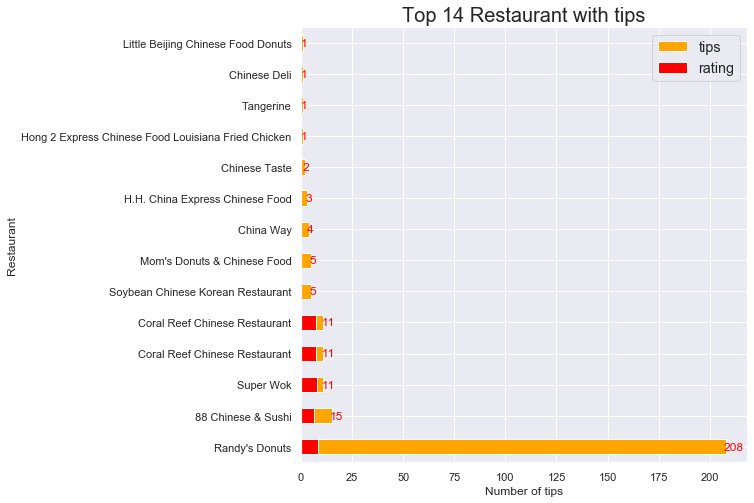

In [735]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

df_tips.plot(kind='barh', figsize=(8, 8), color='orange',label='tips')
df_rating.plot(kind='barh', figsize=(8, 8), color='red',label='rating')



plt.xlabel('Number of tips')
plt.ylabel('Restaurant')
plt.title('Top 14 Restaurant with tips',size=20)
# annotate value labels to each country
for index, value in enumerate(df_tips): 
    labels = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(labels, xy=(value-1, index-0.1 ), color='red')
plt.legend(loc="upper right",fontsize='large')
plt.show()

# Now Lets focu on the top5 hot restaurant

In [778]:
chin_eat

restaurant            categories  \
0                                      Randy's Donuts            Donut Shop   
1                                  88 Chinese & Sushi    Chinese Restaurant   
2                                           Super Wok    Chinese Restaurant   
3                       Coral Reef Chinese Restaurant    Chinese Restaurant   
4                       Coral Reef Chinese Restaurant    Chinese Restaurant   
5                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
6                         Mom's Donuts & Chinese Food            Donut Shop   
7                                           China Way    Chinese Restaurant   
8                     H.H. China Express Chinese Food  Fast Food Restaurant   
9                                       Chinese Taste      Asian Restaurant   
10  Hong 2 Express Chinese Food Louisiana Fried Ch...    Chinese Restaurant   
11                                          Tangerine    Chinese Restaurant   
12                                       Chinese Deli    Chinese Restaurant   
13                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
14                           Abc express chinese food      Asian Restaurant   
15                                     Bamboo Chinese    Chinese Restaurant   
16                             Ming's Chinese Kitchen                  None   
17                                       Chinese Food    Chinese Restaurant   
18                         ABC Donut and Chinese Food    Chinese Restaurant   
19                                  Chinese Food Bowl    Chinese Restaurant   
20                          Panda Garden Chinese Cafe                  Food   
21                          J&J Wok Chinese Fast Food    Chinese Restaurant   
22                       King Express Chinese & Donut    Chinese Restaurant   
23                             Five Star Chinese Food    Chinese Restaurant   
24                        Cha Cha 8 Thai-Chinese Food       Thai Restaurant   
25                           Abc express chinese food      Asian Restaurant   
26                            Wong's Wok Chinese Food    Chinese Restaurant   

          lat         lng                        id  tips  rating  
0   33.961813 -118.370479  4bafd591f964a52088243ce3   208     8.5  
1   34.173906 -118.466181  4b5fba41f964a52033ca29e3    15     6.6  
2   34.169480 -118.535642  4c1adf3ab9f876b0e2777946    11     7.7  
3   34.117639 -118.261024  3fd66200f964a520aeee1ee3    11     7.5  
4   34.117639 -118.261024  3fd66200f964a520aeee1ee3    11     7.5  
5   34.045385 -118.465488  4b01d1e7f964a520b34522e3     5     0.0  
6   34.078782 -118.278669  4b131df6f964a520529423e3     5     0.0  
7   34.091158 -118.291349  4bd9de712a3a0f47ba9ea8b6     4     0.0  
8   33.778663 -118.192067  4dbb1ab24b222080d36f7e49     3     0.0  
9   34.050243 -118.217572  4b8c64dbf964a5208bce32e3     2     0.0  
10  33.916839 -118.282376  513952e2e4b0cff955ca9d14     1     0.0  
11  34.050048 -118.242248  51840930498ef5dc7b535e35     1     0.0  
12  33.808499 -118.265187  4c5b67272815c9281e7daf67     1     0.0  
13  34.081227 -118.177729  4edd69b28b8173160fefdb72     1     0.0  
14  34.181225 -118.535851  4eb34c90cc2143e8271159b6     0     0.0  
15  34.083383 -118.304932  59c80a372079556b588a1aae     0     0.0  
16  34.247037 -118.277801  4cd3859a72a1a1cd41d56551     0     0.0  
17  34.101747 -118.322066  4ef27ac7d3e3e3805862c18e     0     0.0  
18  34.104165 -118.330221  4b8850ecf964a5209fee31e3     0     0.0  
19  34.028262 -118.260125  4e6e80d01495941d568b971f     0     0.0  
20  34.097978 -118.335284  4f43bc5c19834bc91f589409     0     0.0  
21  34.026995 -118.258061  4defc56fc65bf3f03e9ee88a     0     0.0  
22  34.194392 -118.396150  4bef6c3f5e4aa593840c59bb     0     0.0  
23  34.073434 -118.213967  4e77f809e4cd130429bf3263     0     0.0  
24  34.218249 -118.449231  510ae292e4b0ca1794256681     0     0.0  
25  34.181225 -118.535851  4eb34c90cc2143e8271159b6     0     

In [776]:
strloc

Street       Lati       Longi
0          ALAMEDA ST  34.286918 -118.711384
1       NEWCASTLE AVE  34.189291 -118.659593
2          JUSTICE ST  34.186423 -118.655813
3      CAPISTRANO AVE  34.220179 -118.651933
4           MARCH AVE  34.187765 -118.648675
..                ...        ...         ...
392        WORKMAN ST  34.091426 -118.150248
393    HENRY FORD AVE  34.137115 -118.127018
394  OCEAN FRONT WALK  34.160964 -118.054681
395         AVENUE 58  33.906097 -118.010709
396       EDGEWARE RD  33.949858 -118.009245

[397 rows x 3 columns]

In [777]:
la_merged

Street       Lati       Longi  Cluster Labels  \
0          ALAMEDA ST  34.286918 -118.711384             5.0   
1       NEWCASTLE AVE  34.189291 -118.659593             3.0   
2          JUSTICE ST  34.186423 -118.655813             5.0   
3      CAPISTRANO AVE  34.220179 -118.651933             5.0   
4           MARCH AVE  34.187765 -118.648675             0.0   
..                ...        ...         ...             ...   
392        WORKMAN ST  34.091426 -118.150248             0.0   
393    HENRY FORD AVE  34.137115 -118.127018             0.0   
394  OCEAN FRONT WALK  34.160964 -118.054681             5.0   
395         AVENUE 58  33.906097 -118.010709             3.0   
396       EDGEWARE RD  33.949858 -118.009245             5.0   

    1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0             Coffee Shop         Grocery Store               Pharmacy   
1          Baseball Field                  Park           Tennis Court   
2            Tennis Court            Sports Bar  Performing Arts Venue   
3      Miscellaneous Shop           Yoga Studio            Flower Shop   
4                     NaN                   NaN                    NaN   
..                    ...                   ...                    ...   
392                   NaN                   NaN                    NaN   
393                   NaN                   NaN                    NaN   
394           Coffee Shop    Mexican Restaurant    American Restaurant   
395                  Park          Tennis Court             Water Park   
396   Rental Car Location    Mexican Restaurant    Japanese Restaurant   

    4th Most Common Venue 5th Most Common Venue  
0          Sandwich Place          Liquor Store  
1     Fried Chicken Joint     French Restaurant  
2                    Park                   Spa  
3          Farmers Market  Fast Food Restaurant  
4                     NaN                   NaN  
..                    ...                   ...  
392                   NaN                   NaN  
393                   NaN                   NaN  
394        Cosmetics Shop                  Bank  
395     College Cafeteria             Disc Golf  
396                  Park             Gift Shop  

[397 rows x 9 columns]

### Lets find which neiborhood does the street belong to

In [785]:
lac=chin_eat['lat']
loc=chin_eat['lng']
las=la_merged['Lati']
los=la_merged['Longi']
oplist=list()
bestlist=list()
namelist=list()
for x,y in zip(lac,loc):
    vector1=np.array([x,y])
    for m,n in zip(las,los):
        vector2=np.array([m,n])
        op=np.linalg.norm(vector1-vector2)
        oplist.append(op)
    value=oplist.index(min(oplist))
    namelist.append(value)
    oplist.clear()
namelist

[233,
 105,
 54,
 324,
 324,
 107,
 303,
 295,
 380,
 361,
 299,
 342,
 319,
 385,
 55,
 280,
 308,
 277,
 273,
 323,
 271,
 330,
 200,
 365,
 120,
 55,
 39]

In [786]:
len(namelist)

27

In [792]:
streetlist=list()
clusterlist=list()
for n in namelist:
    streetlist.append(la_merged['Street'][n])
    clusterlist.append(la_merged['Cluster Labels'][n])
print(clusterlist)
streetlist

[1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 1.0, 2.0, 5.0, 1.0, 3.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 5.0, 2.0, 2.0]


['98TH ST',
 'LENNOX AVE',
 'BLYTHE ST',
 'ECHO PARK AVE',
 'ECHO PARK AVE',
 'MIDVALE AVE',
 'BULLARD AVE',
 '25TH ST',
 'WESTMONT DR',
 '4TH PL',
 'BARING CROSS ST',
 'STANFORD AVE',
 '112TH ST',
 'ALCAZAR ST',
 'VALERIO ST',
 'MONTE VISTA ST',
 'SILVERTON AVE',
 'RUBY PL',
 'NEW HAMPSHIRE AVE',
 '34TH ST',
 'KINGSLEY DR',
 'CRESCENT HEIGHTS BLVD',
 'LAUREL CANYON BLVD',
 'BREED ST',
 'LANARK ST',
 'VALERIO ST',
 'RESEDA BLVD']

In [793]:
streetlist = pd.DataFrame(streetlist)
clusterlist = pd.DataFrame(clusterlist)
chin_eat = pd.concat([chin_eat,streetlist,clusterlist],axis=1)

In [794]:
chin_eat

restaurant            categories  \
0                                      Randy's Donuts            Donut Shop   
1                                  88 Chinese & Sushi    Chinese Restaurant   
2                                           Super Wok    Chinese Restaurant   
3                       Coral Reef Chinese Restaurant    Chinese Restaurant   
4                       Coral Reef Chinese Restaurant    Chinese Restaurant   
5                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
6                         Mom's Donuts & Chinese Food            Donut Shop   
7                                           China Way    Chinese Restaurant   
8                     H.H. China Express Chinese Food  Fast Food Restaurant   
9                                       Chinese Taste      Asian Restaurant   
10  Hong 2 Express Chinese Food Louisiana Fried Ch...    Chinese Restaurant   
11                                          Tangerine    Chinese Restaurant   
12                                       Chinese Deli    Chinese Restaurant   
13                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
14                           Abc express chinese food      Asian Restaurant   
15                                     Bamboo Chinese    Chinese Restaurant   
16                             Ming's Chinese Kitchen                  None   
17                                       Chinese Food    Chinese Restaurant   
18                         ABC Donut and Chinese Food    Chinese Restaurant   
19                                  Chinese Food Bowl    Chinese Restaurant   
20                          Panda Garden Chinese Cafe                  Food   
21                          J&J Wok Chinese Fast Food    Chinese Restaurant   
22                       King Express Chinese & Donut    Chinese Restaurant   
23                             Five Star Chinese Food    Chinese Restaurant   
24                        Cha Cha 8 Thai-Chinese Food       Thai Restaurant   
25                           Abc express chinese food      Asian Restaurant   
26                            Wong's Wok Chinese Food    Chinese Restaurant   

          lat         lng                        id  tips  rating  \
0   33.961813 -118.370479  4bafd591f964a52088243ce3   208     8.5   
1   34.173906 -118.466181  4b5fba41f964a52033ca29e3    15     6.6   
2   34.169480 -118.535642  4c1adf3ab9f876b0e2777946    11     7.7   
3   34.117639 -118.261024  3fd66200f964a520aeee1ee3    11     7.5   
4   34.117639 -118.261024  3fd66200f964a520aeee1ee3    11     7.5   
5   34.045385 -118.465488  4b01d1e7f964a520b34522e3     5     0.0   
6   34.078782 -118.278669  4b131df6f964a520529423e3     5     0.0   
7   34.091158 -118.291349  4bd9de712a3a0f47ba9ea8b6     4     0.0   
8   33.778663 -118.192067  4dbb1ab24b222080d36f7e49     3     0.0   
9   34.050243 -118.217572  4b8c64dbf964a5208bce32e3     2     0.0   
10  33.916839 -118.282376  513952e2e4b0cff955ca9d14     1     0.0   
11  34.050048 -118.242248  51840930498ef5dc7b535e35     1     0.0   
12  33.808499 -118.265187  4c5b67272815c9281e7daf67     1     0.0   
13  34.081227 -118.177729  4edd69b28b8173160fefdb72     1     0.0   
14  34.181225 -118.535851  4eb34c90cc2143e8271159b6     0     0.0   
15  34.083383 -118.304932  59c80a372079556b588a1aae     0     0.0   
16  34.247037 -118.277801  4cd3859a72a1a1cd41d56551     0     0.0   
17  34.101747 -118.322066  4ef27ac7d3e3e3805862c18e     0     0.0   
18  34.104165 -118.330221  4b8850ecf964a5209fee31e3     0     0.0   
19  34.028262 -118.260125  4e6e80d01495941d568b971f     0     0.0   
20  34.097978 -118.335284  4f43bc5c19834bc91f589409     0     0.0   
21  34.026995 -118.258061  4defc56fc65bf3f03e9ee88a     0     0.0   
22  34.194392 -118.396150  4bef6c3f5e4aa593840c59bb     0     0.0   
23  34.073434 -118.213967  4e77f809e4cd130429bf3263     0     0.0   
24  34.218249 -118.449231  510ae292e4b0ca1794256681     0     0.0   
25  34.181225 -118.535851  4eb34c90c

### Now we integrate the information including restaturants, streets, cluster, tips, ratings etc.

In [795]:
headers=['restaurant','categories','lat','lng','id','tips','rating','street','street1','cluster']
chin_eat.columns=headers
chin_eat = chin_eat.drop('street1',axis=1)
chin_eat

restaurant            categories  \
0                                      Randy's Donuts            Donut Shop   
1                                  88 Chinese & Sushi    Chinese Restaurant   
2                                           Super Wok    Chinese Restaurant   
3                       Coral Reef Chinese Restaurant    Chinese Restaurant   
4                       Coral Reef Chinese Restaurant    Chinese Restaurant   
5                   Soybean Chinese Korean Restaurant    Chinese Restaurant   
6                         Mom's Donuts & Chinese Food            Donut Shop   
7                                           China Way    Chinese Restaurant   
8                     H.H. China Express Chinese Food  Fast Food Restaurant   
9                                       Chinese Taste      Asian Restaurant   
10  Hong 2 Express Chinese Food Louisiana Fried Ch...    Chinese Restaurant   
11                                          Tangerine    Chinese Restaurant   
12                                       Chinese Deli    Chinese Restaurant   
13                 Little Beijing Chinese Food Donuts    Chinese Restaurant   
14                           Abc express chinese food      Asian Restaurant   
15                                     Bamboo Chinese    Chinese Restaurant   
16                             Ming's Chinese Kitchen                  None   
17                                       Chinese Food    Chinese Restaurant   
18                         ABC Donut and Chinese Food    Chinese Restaurant   
19                                  Chinese Food Bowl    Chinese Restaurant   
20                          Panda Garden Chinese Cafe                  Food   
21                          J&J Wok Chinese Fast Food    Chinese Restaurant   
22                       King Express Chinese & Donut    Chinese Restaurant   
23                             Five Star Chinese Food    Chinese Restaurant   
24                        Cha Cha 8 Thai-Chinese Food       Thai Restaurant   
25                           Abc express chinese food      Asian Restaurant   
26                            Wong's Wok Chinese Food    Chinese Restaurant   

          lat         lng                        id  tips  rating  \
0   33.961813 -118.370479  4bafd591f964a52088243ce3   208     8.5   
1   34.173906 -118.466181  4b5fba41f964a52033ca29e3    15     6.6   
2   34.169480 -118.535642  4c1adf3ab9f876b0e2777946    11     7.7   
3   34.117639 -118.261024  3fd66200f964a520aeee1ee3    11     7.5   
4   34.117639 -118.261024  3fd66200f964a520aeee1ee3    11     7.5   
5   34.045385 -118.465488  4b01d1e7f964a520b34522e3     5     0.0   
6   34.078782 -118.278669  4b131df6f964a520529423e3     5     0.0   
7   34.091158 -118.291349  4bd9de712a3a0f47ba9ea8b6     4     0.0   
8   33.778663 -118.192067  4dbb1ab24b222080d36f7e49     3     0.0   
9   34.050243 -118.217572  4b8c64dbf964a5208bce32e3     2     0.0   
10  33.916839 -118.282376  513952e2e4b0cff955ca9d14     1     0.0   
11  34.050048 -118.242248  51840930498ef5dc7b535e35     1     0.0   
12  33.808499 -118.265187  4c5b67272815c9281e7daf67     1     0.0   
13  34.081227 -118.177729  4edd69b28b8173160fefdb72     1     0.0   
14  34.181225 -118.535851  4eb34c90cc2143e8271159b6     0     0.0   
15  34.083383 -118.304932  59c80a372079556b588a1aae     0     0.0   
16  34.247037 -118.277801  4cd3859a72a1a1cd41d56551     0     0.0   
17  34.101747 -118.322066  4ef27ac7d3e3e3805862c18e     0     0.0   
18  34.104165 -118.330221  4b8850ecf964a5209fee31e3     0     0.0   
19  34.028262 -118.260125  4e6e80d01495941d568b971f     0     0.0   
20  34.097978 -118.335284  4f43bc5c19834bc91f589409     0     0.0   
21  34.026995 -118.258061  4defc56fc65bf3f03e9ee88a     0     0.0   
22  34.194392 -118.396150  4bef6c3f5e4aa593840c59bb     0     0.0   
23  34.073434 -118.213967  4e77f809e4cd130429bf3263     0     0.0   
24  34.218249 -118.449231  510ae292e4b0ca1794256681     0     0.0   
25  34.181225 -118.535851  4eb34c90c

### Select the streets with cluster 5 that are similar to the streets where the existing Chinese restaurants belong to .

In [801]:
cluster5 = la_merged[la_merged['Cluster Labels']==5.0]
cluster5

Street       Lati       Longi  Cluster Labels  \
0          ALAMEDA ST  34.286918 -118.711384             5.0   
2          JUSTICE ST  34.186423 -118.655813             5.0   
3      CAPISTRANO AVE  34.220179 -118.651933             5.0   
5         HATTERAS ST  34.227583 -118.646692             5.0   
6          SYLMAR AVE  34.189901 -118.644897             5.0   
..                ...        ...         ...             ...   
379       ALVARADO ST  33.768715 -118.189399             5.0   
381         SANTEE ST  33.773538 -118.189380             5.0   
383          DOBBS ST  34.085986 -118.182518             5.0   
394  OCEAN FRONT WALK  34.160964 -118.054681             5.0   
396       EDGEWARE RD  33.949858 -118.009245             5.0   

    1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0             Coffee Shop         Grocery Store               Pharmacy   
2            Tennis Court            Sports Bar  Performing Arts Venue   
3      Miscellaneous Shop           Yoga Studio            Flower Shop   
5                Tea Room           Yoga Studio            Flower Shop   
6    Fast Food Restaurant           Pizza Place     Mexican Restaurant   
..                    ...                   ...                    ...   
379               Brewery                 Plaza                    Bar   
381              Pharmacy    Mexican Restaurant                 Bakery   
383    Mexican Restaurant     Convenience Store              BBQ Joint   
394           Coffee Shop    Mexican Restaurant    American Restaurant   
396   Rental Car Location    Mexican Restaurant    Japanese Restaurant   

         4th Most Common Venue 5th Most Common Venue  
0               Sandwich Place          Liquor Store  
2                         Park                   Spa  
3               Farmers Market  Fast Food Restaurant  
5                         Farm        Farmers Market  
6           Chinese Restaurant           Coffee Shop  
..                         ...                   ...  
379                Pizza Place           Coffee Shop  
381                Pizza Place        Clothing Store  
383  South American Restaurant      Asian Restaurant  
394             Cosmetics Shop                  Bank  
396                       Park             Gift Shop  

[256 rows x 9 columns]

In [809]:


# create map
map_clusters = folium.Map(location=[34.16090, -118.010], zoom_start=11)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster5['Lati'],cluster5['Longi'], cluster5['Street'], cluster5['Cluster Labels']):

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='steelblue',
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lon, poi, cluster in zip(chin_eat['lat'][0:5],chin_eat['lng'][0:5], chin_eat['restaurant'][0:5],
                                  chin_eat['cluster'][0:5]):

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

# Visualize Crime Rate Factor

Now, Lets consider the crime rate factor. The reason why I choose the crime rate factor and population factor is that 
I cannot find much various meta data with high quality, which means that it has a direct relationship with the streets in LA.

My goal is to find an area with a good combination of relatively low crime rate and high population.

In [821]:
crime.iloc[1000:1050]

DR_NO               Date Rptd                DATE OCC  TIME OCC  \
1000  171320108  09/09/2017 12:00:00 AM  09/09/2017 12:00:00 AM      1810   
1001  171904790  01/16/2017 12:00:00 AM  01/16/2017 12:00:00 AM      2056   
1002  171808143  03/16/2017 12:00:00 AM  03/16/2017 12:00:00 AM      1922   
1003  171211851  04/19/2017 12:00:00 AM  04/19/2017 12:00:00 AM      1825   
1004  171509756  04/07/2017 12:00:00 AM  04/07/2017 12:00:00 AM      1000   
1005  151212362  05/02/2015 12:00:00 AM  05/02/2015 12:00:00 AM      2340   
1006  151313328  06/19/2015 12:00:00 AM  06/19/2015 12:00:00 AM      2250   
1007  151220372  08/29/2015 12:00:00 AM  08/29/2015 12:00:00 AM        50   
1008  151115066  08/11/2015 12:00:00 AM  08/11/2015 12:00:00 AM       245   
1009  151207204  02/22/2015 12:00:00 AM  01/17/2015 12:00:00 AM      1245   
1010  150517553  11/03/2015 12:00:00 AM  11/03/2015 12:00:00 AM      1044   
1011  151804154  01/05/2015 12:00:00 AM  01/04/2015 12:00:00 AM      1900   
1012  150200579  02/15/2015 12:00:00 AM  02/15/2015 12:00:00 AM       828   
1013  151317874  09/10/2015 12:00:00 AM  09/10/2015 12:00:00 AM      2000   
1014  151604033  01/02/2015 12:00:00 AM  01/02/2015 12:00:00 AM       755   
1015  151214222  05/31/2015 12:00:00 AM  05/31/2015 12:00:00 AM       350   
1016  151210775  04/09/2015 12:00:00 AM  04/08/2015 12:00:00 AM      2330   
1017  151916761  08/21/2015 12:00:00 AM  08/21/2015 12:00:00 AM       454   
1018  151318610  09/25/2015 12:00:00 AM  09/25/2015 12:00:00 AM      2310   
1019  151317036  08/25/2015 12:00:00 AM  08/25/2015 12:00:00 AM      2245   
1020  151313465  06/21/2015 12:00:00 AM  06/21/2015 12:00:00 AM      2330   
1021  150611173  04/22/2015 12:00:00 AM  04/22/2015 12:00:00 AM       835   
1022  152010985  05/25/2015 12:00:00 AM  05/25/2015 12:00:00 AM      2310   
1023  151015594  10/02/2015 12:00:00 AM  01/01/2015 12:00:00 AM         6   
1024  150407618  03/21/2015 12:00:00 AM  03/21/2015 12:00:00 AM      1853   
1025  151214262  05/31/2015 12:00:00 AM  05/31/2015 12:00:00 AM      2225   
1026  151413396  04/28/2015 12:00:00 AM  04/28/2015 12:00:00 AM      2103   
1027  150905473  01/31/2015 12:00:00 AM  01/31/2015 12:00:00 AM       527   
1028  150219706  10/19/2015 12:00:00 AM  10/18/2015 12:00:00 AM      2310   
1029  151224228  10/25/2015 12:00:00 AM  10/24/2015 12:00:00 AM      2200   
1030  151900574  01/22/2015 12:00:00 AM  01/22/2015 12:00:00 AM      2145   
1031  150213501  06/24/2015 12:00:00 AM  06/23/2015 12:00:00 AM      2204   
1032  150801409  09/22/2015 12:00:00 AM  09/21/2015 12:00:00 AM       600   
1033  151308096  03/13/2015 12:00:00 AM  03/13/2015 12:00:00 AM      2345   
1034  151519313  10/04/2015 12:00:00 AM  10/04/2015 12:00:00 AM      2115   
1035  151206235  02/03/2015 12:00:00 AM  02/02/2015 12:00:00 AM      2015   
1036  151921361  11/06/2015 12:00:00 AM  11/06/2015 12:00:00 AM      1745   
1037  150604256  01/04/2015 12:00:00 AM  01/04/2015 12:00:00 AM      2355   
1038  150315753  07/05/2015 12:00:00 AM  07/04/2015 12:00:00 AM      2250   
1039  151318231  09/18/2015 12:00:00 AM  09/18/2015 12:00:00 AM        25   
1040  150505318  01/29/2015 12:00:00 AM  01/29/2015 12:00:00 AM      2008   
1041  151818010  09/27/2015 12:00:00 AM  09/27/2015 12:00:00 AM      1420   
1042  150113993  06/03/2015 12:00:00 AM  03/23/2015 12:00:00 AM      1346   
1043  151914863  07/19/2015 12:00:00 AM  07/18/2015 12:00:00 AM      2330   
1044  151412943  04/22/2015 12:00:00 AM  04/22/2015 12:00:00 AM      1427   
1045  151209436  03/20/2015 12:00:00 AM  03/20/2015 12:00:00 AM       200   
1046  150315013  06/22/2015 12:00:00 AM  06/21/2015 12:00:00 AM      2310   
1047  150222118  12/07/2015 12:00:00 AM  12/06/2015 12:00:00 AM      2200   
1048  190517850  01/23/2019 12:00:00 AM  08/30/2015 12:00:00 AM      1827   
1049  150311180  04/23/2015 12:00:00 AM  04/23/2015 12:00:00 AM      2340   

      AREA     AREA NAME  Rpt Dist No  Part 1-2  Crm Cd        Crm Cd Desc  \
1000

In [7]:
crimedata = crime.groupby('AREA NAME').size()

crimedata = crimedata.sort_values(ascending=False).reset_index()
num = range(21)
numm = list()
for n in num:
    numm.append(n+1)
numm = pd.DataFrame(numm)
crimedata = pd.concat([crimedata,numm],axis=1)
header= ['AREA NAME','counts','rank']
crimedata.columns=header
crimedata.to_excel('/Users/liyibo/Desktop/crimedata.xlsx')
crimedata

AREA NAME  counts  rank
0   77th Street     438     1
1     Southeast     377     2
2        Newton     241     3
3     Southwest     220     4
4    Hollenbeck     171     5
5        Harbor     166     6
6       Rampart     147     7
7       Mission     135     8
8      Foothill     113     9
9       Central     110    10
10    Northeast      89    11
11  N Hollywood      82    12
12      Olympic      82    13
13    Hollywood      68    14
14     Van Nuys      61    15
15  West Valley      59    16
16     Wilshire      57    17
17      Pacific      51    18
18   Devonshire      44    19
19      Topanga      38    20
20      West LA      24    21

In [29]:
cc=crime.groupby('AREA NAME').head(1)
col=['AREA NAME','LAT','LON']
cc=cc[col].reset_index()
cc=cc.drop('index',axis=1)
cc = cc.join(crimedata.set_index('AREA NAME'), on='AREA NAME')
cc

AREA NAME      LAT       LON  counts  rank
0   77th Street  33.9660 -118.2783     438     1
1    Hollenbeck  34.0700 -118.1998     171     5
2     Southeast  33.9314 -118.2671     377     2
3   West Valley  34.1866 -118.5011      59    16
4    Devonshire  34.2646 -118.4761      44    19
5       Olympic  34.0596 -118.3022      82    13
6        Harbor  33.7753 -118.2456     166     6
7     Southwest  34.0132 -118.2915     220     4
8       Central  34.0417 -118.2398     110    10
9       Rampart  34.0413 -118.2742     147     7
10    Hollywood  34.0862 -118.3078      68    14
11     Van Nuys  34.1721 -118.4509      61    15
12  N Hollywood  34.1994 -118.4052      82    12
13       Newton  33.9833 -118.2739     241     3
14    Northeast  34.1164 -118.1749      89    11
15      Pacific  33.9981 -118.4741      51    18
16     Foothill  34.2749 -118.3955     113     9
17      Mission  34.3189 -118.4124     135     8
18     Wilshire  34.0498 -118.3706      57    17
19      Topanga  34.2259 -118.6126      38    20
20      West LA  34.0584 -118.4247      24    21

In [813]:
df.head()

Name  TotalPopulation     Owner   Renter       Lati  \
20  HISTORIC CULTURAL NC         20010.32    838.77  6008.04  39.778275   
66           WESTSIDE NC         31659.94   7462.54  6741.44  32.645134   
11         EAGLE ROCK NC         31812.31   5839.30  4752.25  35.251784   
37   NORTHRIDGE SOUTH NC         32525.30   5294.53  5269.24  36.537638   
62         WEST HILLS NC         36972.87  10577.95  1945.08  36.030698   

        Longi  
20 -86.169329  
66 -85.402725  
11 -82.538177  
37 -79.735313  
62 -78.983065

In [843]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.



In [37]:
import json
import requests
import folium

from folium import plugins
url = '/Users/liyibo/Desktop/capstone/Neighborhoods.geojson' 
san_geo = f'{url}'
g_map=folium.Map(location=[33.77,-118.4],zoom_start=12) 

folium.GeoJson(san_geo,style_function=
               lambda feature:{'fillColor':'#ffff00','color':'blue','weight':2,'dashArray':'5,5'}).add_to(g_map)
s=['AREA NAME','counts']
showdata=pd.DataFrame(crimedata[s])
print(showdata)
from folium.plugins import HeatMap

lat = np.array(cc["LAT"])                        
lon = np.array(cc["LON"])                        
pop = np.array(cc["counts"],dtype=float)    
data1 = [[lat[i],lon[i],pop[i]] for i in range(20)]
HeatMap(data1).add_to(g_map)
g_map

      AREA NAME  counts
0   77th Street     438
1     Southeast     377
2        Newton     241
3     Southwest     220
4    Hollenbeck     171
5        Harbor     166
6       Rampart     147
7       Mission     135
8      Foothill     113
9       Central     110
10    Northeast      89
11  N Hollywood      82
12      Olympic      82
13    Hollywood      68
14     Van Nuys      61
15  West Valley      59
16     Wilshire      57
17      Pacific      51
18   Devonshire      44
19      Topanga      38
20      West LA      24


# So as you can see:
### by now, we have found the similar streets and also we take crime rate into consideration.
### So we can answer these questions:
1)	Which zone has a relative better safety?
2)	What streets can be considered similar from commercial angle?
3)	Where should I locate my new Chinese Restaurant in LA?

### Thanks for watching!